## Simple CNN

A simple walkthrough of how to code a convolutional neural network (CNN)
using the PyTorch library. For demonstration we train it on the very
common MNIST dataset of handwritten digits. In this code we go through
how to create the network as well as initialize a loss function, optimizer,
check accuracy and more.

In [27]:
# Import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from tqdm import tqdm

## Chuẩn bị dữ liệu

---

In [28]:

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)

# Chia train thành train_val_dataset: 80% và val_dataset: 20%
len_train_dataset = int(len(train_dataset) * 0.8)
len_val_dataset = len(train_dataset) - len_train_dataset

train_dataset, val_dataset = random_split(train_dataset, [len_train_dataset, len_val_dataset])

# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [29]:
# Get the first batch from the test_loader
first_batch = next(iter(test_loader))

# You can then inspect the batch, for example, print the shape of the images and labels
images, labels = first_batch
print("Shape of images in the first batch:", images.shape)
print("Shape of labels in the first batch:", labels.shape)

Shape of images in the first batch: torch.Size([64, 1, 28, 28])
Shape of labels in the first batch: torch.Size([64])


## Xây dựng mô hình
---

In [30]:
class CNN(nn.Module):
  def __init__(self, in_chanels=1, num_classes=10):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels = in_chanels
        , out_channels = 8
        , kernel_size = 3
        , padding=1
        , stride=1
    )
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(
        in_channels=8
        , out_channels=16
        , kernel_size=3
        , padding=1
        , stride=1
    )
    self.fc1 = nn.Linear(16*7*7, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    return x

## Train mô hình và tinh chỉnh tham số với tập val

In [38]:
# Khai báo parameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 1
num_classes = 10
learning_rate = 0.01
batch_size = 64
num_epochs = 5

# Khai báo mô hình, hàm loss và optimizer
model = CNN(in_chanels=in_channels, num_classes = num_classes).to(device)
criterion = nn.CrossEntropyLoss() # Loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizer


In [39]:
# Hàm check accuracy trên val
def check_accuracy(loader, model):
  num_correct = 0
  num_samples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      # Use cuda if possible
      x = x.to(device=device)
      y = y.to(device=device)

      scores = model(x)
      _, predictions = scores.max(1)
      num_correct += (predictions == y).sum()
      num_samples += predictions.size(0)

  return num_correct/num_samples

In [40]:
# Train mô hình

train_accuracies = []
val_accuracies = []
train_losses = []

for epoch in range(num_epochs):
  running_loss = 0
  for batch_id, (data, targets) in enumerate(tqdm(train_loader)):
    data = data.to(device=device)
    targets = targets.to(device=device)

    # Reshape data
    # data = data.reshape(data.shape[0], -1) # Removed this line

    # Forward
    scores = model(data)
    loss = criterion(scores, targets)

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Gradient
    optimizer.step()

    running_loss += loss.item()

  train_acc = check_accuracy(train_loader, model)
  val_acc = check_accuracy(val_loader, model)  # test_loader là validation set
  avg_train_loss = running_loss / len(train_loader)
  train_accuracies.append(train_acc.item())
  val_accuracies.append(val_acc.item())
  train_losses.append(avg_train_loss)
  print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc*100:.2f}% - Val Acc: {val_acc*100:.2f}%")

100%|██████████| 750/750 [00:16<00:00, 45.01it/s]


Epoch [1/5] - Train Loss: 0.3867 - Train Acc: 96.01% - Val Acc: 95.74%


100%|██████████| 750/750 [00:16<00:00, 44.64it/s]


Epoch [2/5] - Train Loss: 0.1141 - Train Acc: 97.47% - Val Acc: 97.32%


100%|██████████| 750/750 [00:16<00:00, 46.57it/s]


Epoch [3/5] - Train Loss: 0.0827 - Train Acc: 97.99% - Val Acc: 97.70%


100%|██████████| 750/750 [00:17<00:00, 44.07it/s]


Epoch [4/5] - Train Loss: 0.0683 - Train Acc: 98.23% - Val Acc: 97.92%


100%|██████████| 750/750 [00:16<00:00, 46.40it/s]


Epoch [5/5] - Train Loss: 0.0589 - Train Acc: 98.70% - Val Acc: 98.10%


- Vẽ biểu đồ accuracy của hai đường train và validate qua các epoch

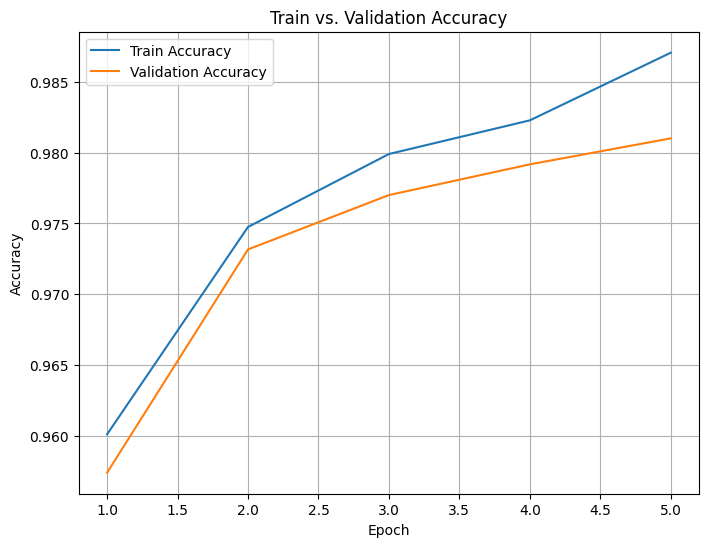

In [41]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ accuracy
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Test Model
---

In [42]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 98.70
Accuracy on test set: 98.29
